# AEWS Python Notebook 09a: complete (pre-batch) WQ algorithm

**Author**: Eric Lehmann, CSIRO Data61  
**Date**: Aug. 02, 2016.

**Note**: this notebook should be accessible and viewable at https://github.com/eric542/agdc_v2/tree/master/notebooks.

## Summary

This notebook brings together all the AEWS components tested / implemented in earlier notebooks. It implements the whole AEWS workflow, starting from the selected ROI and AGDC data, and ultimately creating a NetCDF dataset containing a time series of WQ maps with associated ancillary information. For testing purposes, this is here carried out for a single selected polygon, and thus represents a pre-batch version. A fully automated batch script executed on the NCI will automatically iterate through all the polygons of interest.

This notebook version (09a) is used to test the functionality of this code, with various plots and checks carried out along the way.


## Preliminaries

This (Jupyter) notebook was written for use on the NCI's VDI system, with the following pre-loaded module:

```
 $ module use /g/data/v10/public/modules/modulefiles --append
 $ module load agdc-py2-prod/1.0.3 
```

These Python definitions are only required here for testing purposes:

In [1]:
%matplotlib inline
import matplotlib.image as img
import matplotlib.pyplot as plt

from pylab import rcParams
rcParams['figure.figsize'] = (8,8)   # increase plot size a bit...
rcParams['axes.formatter.useoffset'] = False   # disable scalar formatter / offset in axes labels

The following Python definitions will be needed for the operational / streamlined batch script:

In [2]:
import numpy as np
import ogr, osr, gdal
import xarray as xr
import os

from netCDF4 import Dataset, num2date, date2num
from datetime import timedelta, datetime    # date

from matplotlib.path import Path   # for point-in-polygon

from scipy import ndimage
from scipy.spatial.distance import pdist

import time as timer
from pprint import pprint
from __future__ import print_function

import datacube.api
from datacube.analytics.analytics_engine import AnalyticsEngine
from datacube.execution.execution_engine import ExecutionEngine

In [3]:
def expand_mask(mask_arr, npix):
    # Uses the True/False (masked/non-masked) values in the array 'mask_arr' and 
    # expands the True values spatially by 'npix' pixels. The value 'npix' can be
    # non-integer, i.e. the mask can be expanded by any spatial distance.
    nmid = np.floor(npix)
    nmax = int( nmid*2 + 1 )
    struc = np.zeros((nmax, nmax), dtype='bool')
    for ii in range(nmax):   # create desired binary structure for morphological operation
        for jj in range(ii,nmax):
            if pdist( [[nmid,nmid], [ii,jj]] ) <= npix:
                struc[ii,jj] = True
                struc[jj,ii] = True
    return ndimage.binary_dilation(mask_arr, structure=struc)


def merge_dup_dates(xrda):
    # Takes in an xarray.DataArray 'xrda' as input and merges 
    # datasets (time slices) within it that have the same dates.
    # Returns the modified DataArray and vector of selected dates.
    dates = xrda.coords['time'].values
    n_dates = len( dates )
    
    # Convert UTM times to local dates (d/m/y only):
    str_dates = np.zeros(n_dates).astype('str')
    for ii in range(n_dates):
        str_dates[ii] = str( dates[ii] )[:10]
    
    # Remove duplicated dates:
    rem_ind = np.zeros(n_dates).astype('bool')   # keep track of which duplicated dates to remove
    for ind in range(1,n_dates):
        dup_ind = np.where( str_dates[:ind]==str_dates[ind] )[0]   # check for duplicated date up to current index
        if len( dup_ind )!=0:   # found (at least) one duplicate
            dup_ind = dup_ind[0]   # only use the first index if multiple dates returned
            rem_ind[ind] = True    # remove current date index
            ind_n_nans = np.sum( np.isnan( xrda[ind] ) ) # nr of NaN pixels in each image
            dup_n_nans = np.sum( np.isnan( xrda[dup_ind] ) )
            if ind_n_nans==0:     # current data has no NaN's, use it instead of duplicate date (copy it to lowest index)
                xrda[dup_ind] = xrda[ind]
                xrda['time'].values[dup_ind] = xrda['time'].values[ind]
            elif dup_n_nans!=0:   # if duplicate date has no NaN's: do nothing (use it instead of current date)
                if dup_n_nans<ind_n_nans:   # duplicate date has less NaN's: fill it in with current data
                    tmp = np.where( np.isnan(xrda[dup_ind]) )
                    xrda[dup_ind].values[tmp] = xrda[ind].values[tmp]
                else:   # dup_n_nans>=ind_n_nans -- duplicate date has more NaN's: use it to fill in current data
                    tmp = np.where( np.isnan(xrda[ind]) )
                    xrda[ind].values[tmp] = xrda[dup_ind].values[tmp]
                    xrda[dup_ind] = xrda[ind]   # save results to lowest date index, in case >2 slices have same date
                    xrda['time'].values[dup_ind] = xrda['time'].values[ind]
    
    return xrda[~rem_ind]


def load_wofs_data(wofs_path, min_lon, max_lon, min_lat, max_lat):
    # Returns array of WOFS data for given extents. Can read data from 
    # multiple adjacent tiles if necessary, at most 2 in either direction.
    lon_idx1 = np.floor(min_lon); lon_idx2 = np.floor(max_lon)
    dlon = abs(lon_idx1-lon_idx2)
    lat_idx1 = np.floor(min_lat); lat_idx2 = np.floor(max_lat)
    dlat = abs(lat_idx1-lat_idx2)
    if ( dlon>1 or dlat>1 ):
        raise NotImplementedError("Lake extents span 3 or more WOFS tiles (in at least one dimension).")
    adj_tile_lon = (dlon==1)    # two adjacent 'horizontal' WOFS tiles
    adj_tile_lat = (dlat==1)    # two adjacent 'vertical' WOFS tiles

    # Load the first (top-left) of (potentially) several WOFS tiles:
    WOFS_fname = wofs_path + 'percentWater_{:3.0f}_{:04.0f}.tiff'.format( np.floor(min_lon), np.floor(max_lat) )
    WOFS_dataset = gdal.Open(WOFS_fname)
    if WOFS_dataset==None:
        raise FileNotFoundError( "Cannot open WOFS data file '{}'.".format(WOFS_fname) )
    WOFS_array = WOFS_dataset.ReadAsArray()
    WOFS_geotx = list( WOFS_dataset.GetGeoTransform() )
    WOFS_proj = WOFS_dataset.GetProjection()   # geodetic lat/lon
    # WOFS_srs = osr.SpatialReference( wkt=WOFS_proj )
    WOFS_lonvec = np.arange(WOFS_array.shape[0]) * WOFS_geotx[1] + WOFS_geotx[0]
    WOFS_latvec = np.arange(WOFS_array.shape[1]) * WOFS_geotx[5] + WOFS_geotx[3]
    WOFS_dataset = None   # closes the gdal dataset

    if ( adj_tile_lon ):   # if 2 horizontal tiles, load (top) right tile
        WOFS_fname = wofs_path + 'percentWater_{:3.0f}_{:04.0f}.tiff'.format( np.floor(max_lon), np.floor(max_lat) )
        WOFS_dataset = gdal.Open(WOFS_fname)
        if WOFS_dataset==None:
            raise FileNotFoundError( "Cannot open WOFS data file '{}'.".format(WOFS_fname) )
        wa2 = WOFS_dataset.ReadAsArray()
        wg2 = list( WOFS_dataset.GetGeoTransform() )
        WOFS_lonvec = np.concatenate(( WOFS_lonvec, np.arange(wa2.shape[0]) * wg2[1] + wg2[0] ),0)
        WOFS_array = np.concatenate((WOFS_array,wa2),1)   # column bind
        WOFS_dataset = None   # closes the gdal dataset

    if ( adj_tile_lat ):   # if 2 vertical tiles: load bottom (left) tile
        WOFS_fname = wofs_path + 'percentWater_{:3.0f}_{:04.0f}.tiff'.format( np.floor(min_lon), np.floor(min_lat) )
        WOFS_dataset = gdal.Open(WOFS_fname)
        if WOFS_dataset==None:
            raise FileNotFoundError( "Cannot open WOFS data file '{}'.".format(WOFS_fname) )
        wa2 = WOFS_dataset.ReadAsArray()
        wg2 = list( WOFS_dataset.GetGeoTransform() )
        WOFS_latvec = np.concatenate(( WOFS_latvec, np.arange(wa2.shape[1]) * wg2[5] + wg2[3] ),0)
        WOFS_dataset = None   # closes the gdal dataset

        if ( adj_tile_lon ):   # if 2 horizontal & 2 vertical tiles: load bottom right tile
            WOFS_fname = wofs_path + 'percentWater_{:3.0f}_{:04.0f}.tiff'.format( np.floor(max_lon), np.floor(min_lat) )
            WOFS_dataset = gdal.Open(WOFS_fname)
            if WOFS_dataset==None:
                raise FileNotFoundError( "Cannot open WOFS data file '{}'.".format(WOFS_fname) )
            wa3 = WOFS_dataset.ReadAsArray()
            wa2 = np.concatenate((wa2,wa3),1)   # column bind
            WOFS_dataset = None   # closes the gdal dataset

        WOFS_array = np.concatenate((WOFS_array,wa2),0)   # row bind
    
    # Extract WOFS over region of interest:
    yind_min = np.where( WOFS_lonvec>=min_lon )[0][0]
    yind_max = np.where( WOFS_lonvec<=max_lon )[0][-1]
    WOFS_lonvec = WOFS_lonvec[yind_min:yind_max+1]
    xind_max = np.where( WOFS_latvec>=min_lat )[0][-1]
    xind_min = np.where( WOFS_latvec<=max_lat )[0][0]
    WOFS_latvec = WOFS_latvec[xind_min:xind_max+1]
    WOFS_array = WOFS_array[xind_min:xind_max+1, yind_min:yind_max+1]
    WOFS_geotx[0] = WOFS_geotx[0] + yind_min*WOFS_geotx[1]
    WOFS_geotx[3] = WOFS_geotx[3] + xind_min*WOFS_geotx[5]

    return WOFS_array, WOFS_proj, WOFS_geotx, WOFS_lonvec, WOFS_latvec

In [4]:
### WOFS test
# # res = load_wofs_data(wofs_dir_path, 143.98, 144.08, -31.61, -31.5)
# res = load_wofs_data(wofs_dir_path, 143.90, 144.01, -33.07, -32.97); tmp = res[0]; tmp[tmp>2] = 2
# # res = load_wofs_data(wofs_dir_path, 143.99, 144.01, -34.04, -33.99); tmp = res[0]; tmp[tmp>10] = 10
# 
# tmp = res[0]; tmp[tmp>10] = 10
# plt.imshow(res[0], extent=[res[3][0],res[3][-1],res[4][-1],res[4][0]])
# plt.xlabel('longitude'); plt.ylabel('latitude')
# plt.colorbar(orientation='vertical', shrink=0.65, label='percent water');

## User inputs

In [5]:
lakes_shp_file = '../NSW_lakes/NSW_WaterBody.shp'
   # shape file containing polygons for waterbodies of interest.
lake_min_area = 5000
   # waterbody screening: minimum area size in sq.m. for a waterbody to be considered.
lake_screen_perennial = True
   # waterbody screening flag: keep only perennial waterbodies?
polygon_buffer_width = 1.5
   # buffering of lake edges: distance (in Landsat pixels) from lake edges where pixels are masked out
lake_min_valid_prc = 10.0
   # minimum percentage of valid (non-NaN) extent required for lake to be processed / saved

pix_size_geo = 0.00025   
   # reprojection to geodetic: desired geodetic pixel size
lake_buffer_width_geo = 0.002  
   # buffer width to add around lake polygon extents for processing, in geodetic units

cloud_buffer_width = 12.0
   # buffer width (in Landsat pixels) to add around cloud and cloud shadow pixels in cloud mask

save_dir_path = "/g/data/jr4/vis_data_v2.0/"
   # base directory path where the WQ outputs are saved: will be created if necessary; can contain existing data.
append_to_existing_nc = True
   # flag: append to dataset on file if exists; otherwise, overwrite it.
backup_if_replacing_nc = True
   # flag: if existing dataset is overwritten, create backup first.
    
start_date = '2013-03-01'
   # start date of time window, format YYYY-MM-DD; will be determined from .nc file if exists and if appending
end_date = '2013-05-01'   # None
   # end date, same format: if set to None, will use current date as end date

wofs_dir_path = '/g/data2/fk4/wofs/current/pyramids/WaterSummary/0/'   
   # base path where geoTiff WOFS data is located
wofs_prc_thr = 90.0
   # percentage threshold for WOFS water mask

SWIR2_prc_thr = 1.0
   # percentage threshold for SWIR2 water mask
low_water_prc_thr = 70.0
   # percentage threshold below which the low-water flag is triggered (compared to polygon extents)

WQ_type = 'Alg2:TwoBand_TSS_calib'   # 'Alg1:(red+green)/2'
   # (string) type of water quality algorithm to use in the code below
alert_thresholds = None   # e.g. (2000,2400)
   # red/amber/green thresholds, defined as tuple (green_to_amber,amber_to_red); None if undefined
    
netcdf_time_units = "seconds since 1970-01-01 00:00:00.0"
   # time units to use when saving data to NetCDF format
netcdf_time_calendar = "standard"
   # calendar to use when saving data to NetCDF format

In [6]:
# Definition of satellites whose dataset will be used for WQ processing. These definitions need 
# to be determined on the basis of the current AGDC dataset (module) used.

# Landsat 8 definitions:
sat_1 = { 'API_sat_str' : 'ls8_nbar_albers',  # satellite string for API queries
          'API_plat_str' : 'LANDSAT_8',       # satellite platform string for API queries
          'AE_red_band_str' : 'band_4',       # red band index/string for AE/EE queries for this satellite
          'AE_green_band_str' : 'band_3',     # green band index/string for AE/EE queries for this satellite
          'AE_swir2_band_str' : 'band_7',     # SWIR2 band index/string for AE/EE queries for this satellite
          'green_satur_bit' : 2,              # PQ saturation bit for green band for this satellite
          'red_satur_bit' : 3,                # PQ saturation bit for red band for this satellite
          'swir2_satur_bit' : 7,              # PQ saturation bit for SWIR2 band for this satellite
          'Alg2_calib_fac' : 3957.0,          # calibration constant (multiplicative factor) for selected WQ algorithm
          'Alg2_calib_exp' : 1.6436 }         # calibration constant (exponent) for selected WQ algorithm

# Landsat 7 definitions:
sat_2 = { 'API_sat_str' : 'ls7_nbar_albers',
          'API_plat_str' : 'LANDSAT_7',
          'AE_red_band_str' : 'band_3',
          'AE_green_band_str' : 'band_2', 
          'AE_swir2_band_str' : 'band_7', 
          'green_satur_bit' : 1,
          'red_satur_bit' : 2,
          'swir2_satur_bit' : 7,
          'Alg2_calib_fac' : 3983.0,
          'Alg2_calib_exp' : 1.6246 }

# Landsat 5 definitions:
sat_3 = { 'API_sat_str' : 'ls5_nbar_albers',   # can define LS5 here, even though we don't have any LS5 data
          'API_plat_str' : 'LANDSAT_5',
          'AE_red_band_str' : 'band_3',
          'AE_green_band_str' : 'band_2',
          'AE_swir2_band_str' : 'band_7', 
          'green_satur_bit' : 1,
          'red_satur_bit' : 2,
          'swir2_satur_bit' : 7,
          'Alg2_calib_fac' : 3983.0,
          'Alg2_calib_exp' : 1.6246 }

# # "Any other/future sensor" definitions:
# sat_4 = { 'API_sat_str' : 'SNTL2_nbar_albers',
#           'API_plat_str' : 'SENTINEL_2',
#           'AE_red_band_str' : 'band_11',
#           'AE_green_band_str' : 'band_22',
#           'AE_swir2_band_str' : 'band_99', 
#           'green_satur_bit' : 0,
#           'red_satur_bit' : 1,
#           'swir2_satur_bit' : 2,
#           'Alg2_calib_fac' : 1234.5,
#           'Alg2_calib_exp' : 3.1415926 }

WQ_sats = { 'sat1' : sat_1,   # resulting dictionary of all satellite defs to use
            'sat2' : sat_2,
            'sat3' : sat_3 }
            # 'sat4' : sat_4 }

API_defs = { 'nbar_product_str' : 'nbar',      # NBAR product string
             'pq_product_str' : 'pqa',         # PQ product string
             'pq_band_str' : 'pixelquality',   # PQ band string
             'contig_bit' : 8,      # PQ contiguity bit 
             'land_bit' : 9,        # PQ land/sea bit
             'cloud_bit1' : 10,     # PQ cloud/shadow bits
             'cloud_bit2' : 11,
             'cloud_bit3' : 12,
             'cloud_bit4' : 13 }

## Loading waterbody polygons from `.shp` file

In [7]:
# Open .shp file:
lakes_vec = ogr.Open( lakes_shp_file )
if lakes_vec==None:
    raise FileNotFoundError( "Cannot open shape file '{}'.".format(lakes_shp_file) )
if lakes_vec.GetLayerCount()!=1:
    raise RuntimeError( "File '{}' has 0 or multiple layers (1 expected).".format(lakes_shp_file) )
lakes_lyr = lakes_vec.GetLayer(0)

# List of waterbody names and attributes:
n_ftr = lakes_lyr.GetFeatureCount()
lname_list = list()
peren_list = list()
shape_list = list()
for kk in range( n_ftr ):
    ftr = lakes_lyr.GetFeature(kk)
    lname_list.append(ftr.GetField('hydroname'))   # name
    peren_list.append(ftr.GetField('perennia_1'))   # perennial flag
    shape_list.append(ftr.GetField('shape_STAr'))   # area in sq.m.

# Screen waterbodies of interest:
tmp = ( np.array(shape_list)>=lake_min_area )
if lake_screen_perennial: 
    tmp = ( (np.array(peren_list)=='Perennial') & tmp )
lakes_ftr_idx = np.where(tmp)[0]
n_lakes = len(lakes_ftr_idx)
if n_lakes==0:
    raise RuntimeError( "No waterbody left to process after screening.")
lakes_name_list = [ lname_list[ii] for ii in lakes_ftr_idx ]
shape_list = [ shape_list[ii] for ii in lakes_ftr_idx ]
lakes_dispname_list = lakes_name_list[:]   # list copy

# Check for duplicated names, rename them (append _0, _1, etc.):
renamed_cntr = 0
for kk in range(n_lakes):
    tmp = [ i for i,s in enumerate(lakes_name_list) if s==lakes_name_list[kk] ]
    n_tmp = len(tmp)
    if n_tmp>1:
        renamed_cntr = renamed_cntr + 1
        for ii,tt in enumerate(tmp):
            lakes_name_list[tt] = lakes_name_list[tt] + "_" + str(ii)

lakes_name_list = [ lakes_name_list[ii].replace(" ","_") for ii in range(n_lakes) ]

In [8]:
# Log info:
print( "Shape file '{}' info:".format(lakes_shp_file) )
print( "  There are", n_ftr, "waterbodies in the file '{}'.".format(lakes_shp_file) )
print( "  A total of", n_lakes, "perennial lakes" if lake_screen_perennial else "lakes", 
       "with area of more than", lake_min_area, "sq.m. will be processed." )
print( "  A total of", renamed_cntr, "lake names were re-labelled to avoid duplicates.")

Shape file '../NSW_lakes/NSW_WaterBody.shp' info:
  There are 1947 waterbodies in the file '../NSW_lakes/NSW_WaterBody.shp'.
  A total of 912 perennial lakes with area of more than 5000 sq.m. will be processed.
  A total of 64 lake names were re-labelled to avoid duplicates.


## Miscellaneous

In [9]:
if alert_thresholds==None:
    alert_thresholds = np.nan
else:
    alert_thresholds = np.array(alert_thresholds)
    if len(alert_thresholds)!=2 or alert_thresholds[0]>=alert_thresholds[1]:
        raise RuntimeError("Alert thresholds not defined properly (2 values in increasing order).")

In [10]:
# Create directory if necessary:
if not save_dir_path.endswith("/"):
    save_dir_path = save_dir_path + "/"

if not os.path.exists( save_dir_path ):
    os.makedirs( save_dir_path )
    if not os.path.exists( save_dir_path ):
        raise RuntimeError("Could not create directory '{}'.".format(save_dir_path) )
    print( "Created results directory '{}'.".format(save_dir_path) )

if not wofs_dir_path.endswith("/"):
    wofs_dir_path = wofs_dir_path + "/"

In [11]:
# Projection to use for final maps: here using geodetic, could be user-specific (would require some re-coding)
geo_proj = osr.SpatialReference ()
geo_proj.ImportFromEPSG ( 4326 );

In [12]:
# AGDC defs:
dc = datacube.api.API()
ae = AnalyticsEngine()
ee = ExecutionEngine()

pqbnd = API_defs['pq_band_str']
nbar_prod = API_defs['nbar_product_str']
pq_prod = API_defs['pq_product_str']

contig_bit = API_defs['contig_bit']
land_bit = API_defs['land_bit']
cloud_bit1 = API_defs['cloud_bit1']
cloud_bit2 = API_defs['cloud_bit2']
cloud_bit3 = API_defs['cloud_bit3']
cloud_bit4 = API_defs['cloud_bit4']

cloud_bit_mask = (1<<cloud_bit1 | 1<<cloud_bit2 | 1<<cloud_bit3 | 1<<cloud_bit4)

INFO:datacube.analytics.analytics_engine:Initialise Analytics Module.
INFO:datacube.execution.execution_engine:Initialise Execution Module.


## Iteration over polygons: processing ONE polygon...

The operational batch script will cycle through the polygons. Here we use only one for illustration purpose.

In [13]:
## for ftr in range(n_lakes):   ###############################################################
poly_t0 = timer.time()
ftr = 12   # 17  15 12
print( "Processing polygon nr.", ftr+1, "of", n_lakes, "..." )
print( "  Polygon name:", lakes_dispname_list[ftr] )
print( "  Surface area is {} ha.".format(round(shape_list[ftr]/10000.0,2)) )

Processing polygon nr. 13 of 912 ...
  Polygon name: EIGHT MILE
  Surface area is 329.94 ha.


### Iteration over polygons: ROI polygon coordinates and extents

In [14]:
# Read in polygon coordinates:
lake_ftr = lakes_lyr.GetFeature( lakes_ftr_idx[ftr] )
ring = lake_ftr.GetGeometryRef().GetGeometryRef(0)
poly_array_geo = np.array(ring.GetPoints())[:,0:2]    # lon / lat coords of polygon

tmp1 = min(poly_array_geo[:,0]) - lake_buffer_width_geo
min_lon = (tmp1 // pix_size_geo) * pix_size_geo

tmp2 = max(poly_array_geo[:,0]) + lake_buffer_width_geo
max_lon = (tmp2 // pix_size_geo) * pix_size_geo + pix_size_geo

tmp3 = min(poly_array_geo[:,1]) - lake_buffer_width_geo
min_lat = (tmp3 // pix_size_geo) * pix_size_geo

tmp4 = max(poly_array_geo[:,1]) + lake_buffer_width_geo
max_lat = (tmp4 // pix_size_geo) * pix_size_geo + pix_size_geo

# coordinates of resulting WQ time series:
lon_vec = np.arange(min_lon, max_lon+pix_size_geo, pix_size_geo)
lat_vec = np.arange(min_lat, max_lat+pix_size_geo, pix_size_geo)

In [15]:
# Log info:
print( "  Polygon extents: min lon.:", tmp1, "--> nearest pixel:", min_lon )
print( "                   max lon.:", tmp2, "--> nearest pixel:", max_lon )
print( "                   min lat.:", tmp3, "--> nearest pixel:", min_lat )
print( "                   max lat.:", tmp4, "--> nearest pixel:", max_lat )

  Polygon extents: min lon.: 145.828515999 --> nearest pixel: 145.8285
                   max lon.: 145.892210296 --> nearest pixel: 145.89225
                   min lat.: -30.143219031 --> nearest pixel: -30.14325
                   max lat.: -30.117280595 --> nearest pixel: -30.11725


### Iteration over polygons: check for existing dataset, determine ROI date range

In [16]:
# Check for existing dataset, determine date range:
roi_file_str = lakes_name_list[ftr] + ".nc"
roi_save_name = save_dir_path + roi_file_str
roi_file_exists = os.path.isfile( roi_save_name )
tmp_org = append_to_existing_nc   # for log info only

roi_start_date = datetime( int(start_date[:4]), int(start_date[5:7]), int(start_date[8:10]) )

if append_to_existing_nc:
    if roi_file_exists:
        # read file attributes:
        roi_nc_grp = Dataset(roi_save_name, mode='r')
        roi_nc_dates = roi_nc_grp.variables['time']
        
        # consistency checks between datasets:
        if not (roi_nc_grp.variables['lat'][:]==lat_vec[::-1]).all():
            raise RuntimeError( "Appending to existing NetCDF '{}': different latitudes.".format(roi_save_name) )
        if not (roi_nc_grp.variables['lon'][:]==lon_vec).all():
            raise RuntimeError( "Appending to existing NetCDF '{}': different longitudes.".format(roi_save_name) )
        if not getattr(roi_nc_grp,'WQtype')==WQ_type:
            raise RuntimeError( "Appending to existing NetCDF '{}': different WQ type.".format(roi_save_name) )
        if not roi_nc_dates.calendar==netcdf_time_calendar:
            raise RuntimeError( "Appending to existing NetCDF '{}': different time calendar.".format(roi_save_name) )
        if not roi_nc_dates.units==netcdf_time_units:
            raise RuntimeError( "Appending to existing NetCDF '{}': different time units.".format(roi_save_name) )
        if not getattr(roi_nc_grp,'Name')==lakes_name_list[ftr]:
            raise RuntimeError( "Appending to existing NetCDF '{}': different lake name.".format(roi_save_name) )
        if not getattr(roi_nc_grp,'DisplayName')==lakes_dispname_list[ftr]:
            raise RuntimeError( "Appending to existing NetCDF '{}': different display name.".format(roi_save_name) )
        if not getattr(roi_nc_grp,'EPSG')==geo_proj.GetAttrValue("AUTHORITY", 1):
            raise RuntimeError( "Appending to existing NetCDF '{}': different EPSG.".format(roi_save_name) )
        if not getattr(roi_nc_grp,'LakeType')=="undefined":   # clear/deep,turbid/shallow ... should be defined somehow!
            raise RuntimeError( "Appending to existing NetCDF '{}': different lake type.".format(roi_save_name) )
        
        tmp = getattr(roi_nc_grp,'GAR_thresholds')
        c1 = np.size(tmp)!=np.size(alert_thresholds)
        c2 = (np.size(tmp)==1 and (~np.isnan(tmp) | ~np.isnan(alert_thresholds)))
        c3 = (np.size(tmp)==2 & ~(tmp==alert_thresholds).all())
        if c1 or c2 or c3:
            raise RuntimeError( "Appending to existing NetCDF '{}': different GAR thresholds.".format(roi_save_name) )
        
        if len( roi_nc_dates )==0:
            raise NotImplementedError( "Existing dataset '{}' has 0 dates.".format(roi_save_name) )
        
        # get start date from existing .nc file:
        roi_nc_last_date = num2date( roi_nc_dates[-1], roi_nc_dates.units, 
                                     roi_nc_dates.calendar )   # datetime.datetime object
        roi_start_date = roi_nc_last_date + timedelta(days=1)
        
        roi_nc_grp.close()
    else:   # no existing file: cannot append; set start date from user input
        append_to_existing_nc = False

if end_date==None:
    roi_end_date = datetime.today()
else:
    roi_end_date = datetime( int(end_date[:4]), int(end_date[5:7]), int(end_date[8:10]) )
roi_end_date = roi_end_date  + timedelta(days=1)

In [17]:
# Log info:
if roi_file_exists & tmp_org:
    print( "  Found existing NetCDF file '{}'; will append to it.".format(roi_save_name) )
    print( "    Last date of existing time series:", roi_nc_last_date.strftime('%Y-%m-%d') )
elif ~roi_file_exists & tmp_org:
    print( "  Could not find existing NetCDF file '{}' to append to; will create new file.".format(roi_save_name) )

print( "  Date range for processing:", roi_start_date.strftime('%Y-%m-%d'), "(inclusive) to", 
       roi_end_date.strftime('%Y-%m-%d'), "(exclusive)" )

  Could not find existing NetCDF file '/g/data/jr4/vis_data_v2.0/EIGHT_MILE.nc' to append to; will create new file.
  Date range for processing: 2013-03-01 (inclusive) to 2013-05-02 (exclusive)


In [18]:
if start_date >= end_date:
    raise RuntimeError("Start date of time window is after end date.")   ###############################################
    ### Poly iteration: replace with log info + 'continue' statement!

### Iteration over polygons: load and process AGDC time series

In [19]:
dimensions = { 'lon' : { 'range': (min_lon, max_lon) },
               'lat' : { 'range': (max_lat, min_lat) },
               'time': { 'range': ( (roi_start_date.year, roi_start_date.month, roi_start_date.day), 
                                    (roi_end_date.year, roi_end_date.month, roi_end_date.day) ) } }

allsats_query = { 'product': nbar_prod,
                  'dimensions': dimensions }

allsats_desc = dc.get_descriptor(allsats_query, include_storage_units=False)

In [20]:
### TESTING POWER FUNCTION WITH AE/EE #########################################################################
# dims = dimensions.copy()
# dims['lat'] = {'range': (-30.125, -30.135)}
# dims['lon'] = {'range': (145.855, 145.865)}
# 
# ae.plan = list()   # appears to be "resetting" the AE definitions...
# ae_green = ae.create_array( ('LANDSAT_8', 'nbar'), ['band_4'], dims, 'ae_green' )
# ae_red   = ae.create_array( ('LANDSAT_8', 'nbar'), ['band_3'], dims, 'ae_red' )
# aeWQ = ae.apply_expression( [ae_green, ae_red], '((array1+array2) * 0.00005)', 'aeWQ' )
# ee.execute_plan(ae.plan)
# WQ_xarray = ee.cache['aeWQ']['array_result']['aeWQ']
# print( WQ_xarray[1].load() )
# 
# ae.plan = list()   # appears to be "resetting" the AE definitions...
# ae_green = ae.create_array( ('LANDSAT_8', 'nbar'), ['band_4'], dims, 'ae_green' )
# ae_red   = ae.create_array( ('LANDSAT_8', 'nbar'), ['band_3'], dims, 'ae_red' )
# aeWQ = ae.apply_expression( [ae_green, ae_red], '{}*exp(log((array1+array2)*0.00005)*{})'.format(2.0,1.5), 'aeWQ' )
# # aeWQ = ae.apply_expression( [ae_green, ae_red], '2.0*exp(log((array1+array2)*0.00005)*1.5)', 'aeWQ' )
# # aeWQ = ae.apply_expression( [ae_green, ae_red], '((array1+array2)*0.00005)**2.0', 'aeWQ' )  # no squaring
# # aeWQ = ae.apply_expression( [ae_green, ae_red], 'pow((array1+array2)*0.00005,2.0)', 'aeWQ' )  # crashes
# # aeWQ = ae.apply_expression( [ae_green, ae_red], 'power((array1+array2)*0.00005,2.0)', 'aeWQ' )  # crashes
# # aeWQ = ae.apply_expression( [ae_green, ae_red], '(((array1+array2)*0.00005)**2.0)', 'aeWQ' )  # crashes
# ee.execute_plan(ae.plan)
# WQ_xarray = ee.cache['aeWQ']['array_result']['aeWQ']
# WQ_xarray[1].load()

  Processing LANDSAT_8 data (satellite 1 of 3) ... 
    10 time slices were found for the selected time window and ROI.
    6 time slices left after merging duplicated dates.
    2 time slices left following PQ & polygon masking.
    2 time slices left following SWIR2 masking.
    2 time slices left following buffered polygon masking.
  Processing LANDSAT_7 data (satellite 2 of 3) ... 
    17 time slices were found for the selected time window and ROI.
    11 time slices left after merging duplicated dates.
    6 time slices left following PQ & polygon masking.
    5 time slices left following SWIR2 masking.
    5 time slices left following buffered polygon masking.
  Processing LANDSAT_5 data (satellite 3 of 3) ... 
    Satellite not available in current database for the selected time window and ROI.
  There are 7 time slices in the resulting multi-sensor time series.


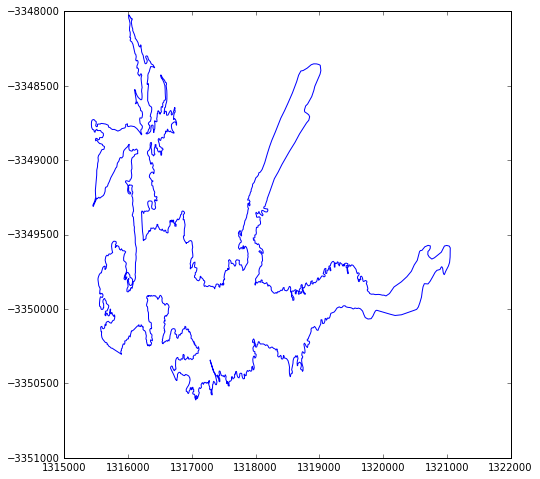

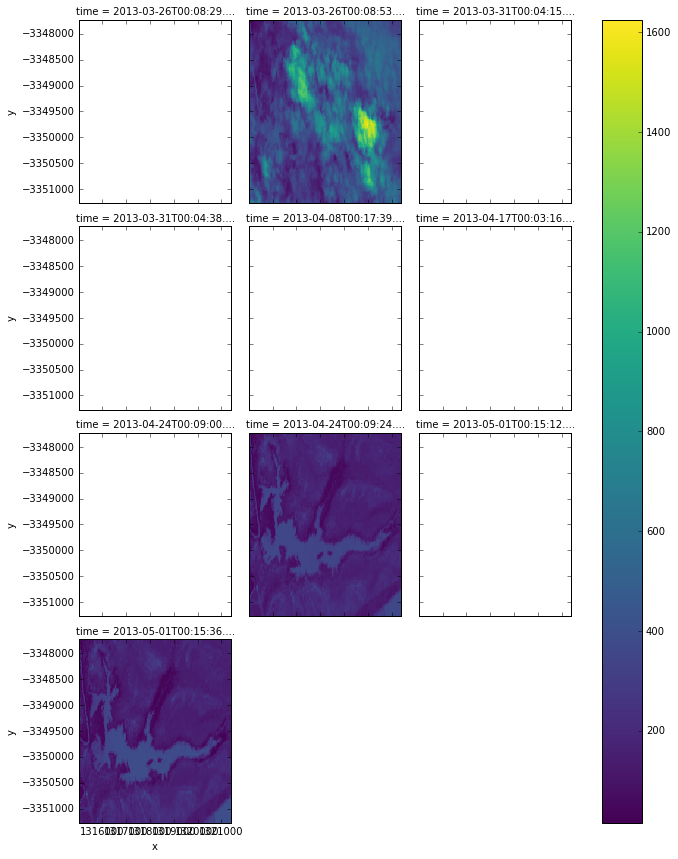

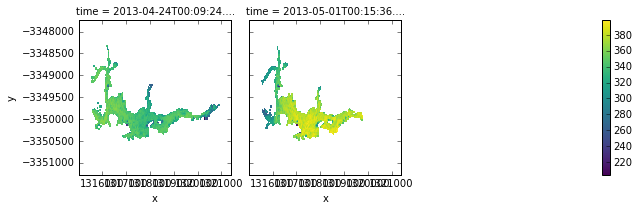

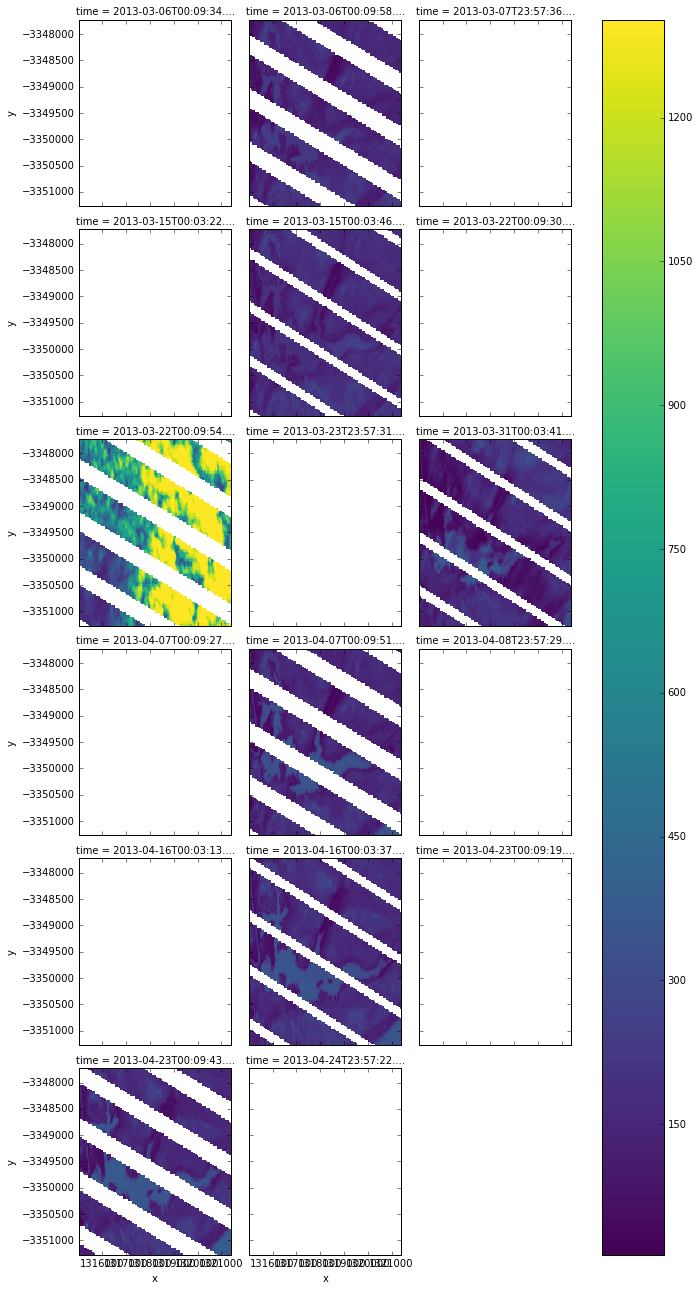

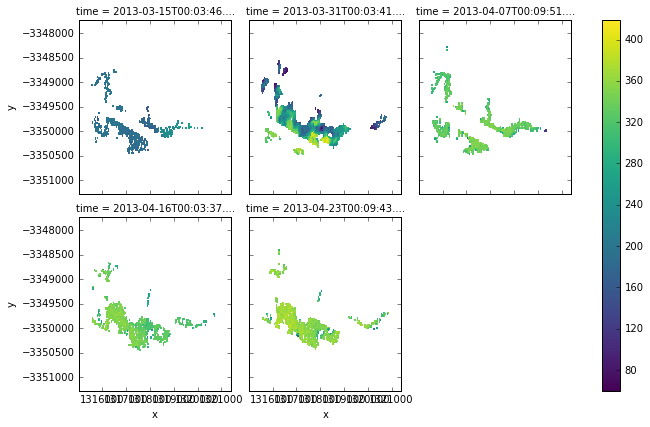

In [21]:
# Cycling through satellites:
n_sats = len(WQ_sats)

proc_init = True
wofs_init = True
concat_init = True
n_dates_orig = 0

for sat in range(n_sats):
    
    ### Check for satellite availability:
    sat_defs = WQ_sats.values()[sat]
    sat_str = sat_defs['API_sat_str']
    plat_str = sat_defs['API_plat_str']
    print( "  Processing", plat_str, "data (satellite", sat+1, "of {}) ... ".format(n_sats) )

    if sat_str not in allsats_desc.keys():
        print( "    Satellite not available in current database for the selected time window and ROI." )
        continue
    
    
    ### Check for data availability:
    query = allsats_query.copy()
    query['platform'] = plat_str
    tmp = dc.get_descriptor(query, include_storage_units=False)
    if tmp[sat_str]['result_shape'][0]==0:
        print( "    No data available in current database for this satellite, for the selected time window and ROI." )
        continue
    
    rbnd = sat_defs['AE_red_band_str']
    gbnd = sat_defs['AE_green_band_str']
    s2bnd = sat_defs['AE_swir2_band_str']
    
    
    ### Load data using AE/EE:
    ae.plan = list()   # appears to be "resetting" the AE definitions...
    ae_green = ae.create_array( (plat_str, nbar_prod), [gbnd], dimensions, 'ae_green' )
    ae_red   = ae.create_array( (plat_str, nbar_prod), [rbnd], dimensions, 'ae_red' )
    ae_swir2 = ae.create_array( (plat_str, nbar_prod), [s2bnd], dimensions, 'ae_swir2' )
    aePQ     = ae.create_array( (plat_str, pq_prod), [pqbnd], dimensions, 'aePQ' )
    
    # selected WQ algorithm:
    if WQ_type=='Alg1:(red+green)/2':
        aeWQ = ae.apply_expression( [ae_green, ae_red], '((array1 + array2) * 0.5)', 'aeWQ' )
    elif WQ_type=='Alg2:TwoBand_TSS_calib':
        cfac = sat_defs['Alg2_calib_fac']
        cexp = sat_defs['Alg2_calib_exp']
        # tmp = '( {} * ((array1 + array2)*0.00005)**{} )'.format(cfac,cexp)   # logical formulation, doesn't work!
        tmp = '{}*exp(log((array1+array2)*0.00005)*{})'.format(cfac,cexp)   # hack to implement the power function...
        aeWQ = ae.apply_expression( [ae_green, ae_red], tmp, 'aeWQ' )
    # elif WQ_type='...':   ... add here further potential WQ algorithms.
    else:
        raise NotImplementedError( "Water quality algorithm '{}' not implemented.".format(WQ_type) )
    
    ee.execute_plan(ae.plan)
    
    WQ_xarray = ee.cache['aeWQ']['array_result']['aeWQ']
    PQ_xarray = ee.cache['aePQ']['array_result'][pqbnd]
    S2_xarray = ee.cache['ae_swir2']['array_result'][s2bnd]
    n_dates = WQ_xarray.shape[0]
    n_dates_orig = n_dates_orig + n_dates
    print( "   ", n_dates, "time slices were found for the selected time window and ROI." )
    
    
    ### Initialise proj. and poly. variables: once-only operations
    if proc_init:
        proc_init = False

        # Satellite projection data: assume all satellites have same projection!
        tmp = dc.get_data( query )   # will hopefully be part of the ee.cache results at some stage
        sat_proj_str = tmp['coordinate_reference_systems'][1]['reference_system_definition']
        sat_proj = osr.SpatialReference( wkt=sat_proj_str )

        sat_xvec = WQ_xarray['x'].values
        sat_yvec = WQ_xarray['y'].values

        sat_pix_size = sat_xvec[1] - sat_xvec[0]   # assume uniform square pixels
        sat_geotx = ( sat_xvec[0], sat_pix_size, 0, sat_yvec[0], 0, -sat_pix_size )

        # Polygon mask:
        geo_to_sat_proj_tx = osr.CoordinateTransformation( geo_proj, sat_proj )
        tmp = geo_to_sat_proj_tx.TransformPoints( poly_array_geo )
        poly_array_xy = np.array( tmp )[:,:2]
        polyPath = Path(poly_array_xy)
        poly_mask_xy = np.ones(WQ_xarray.shape[1:], dtype='bool')

        jj1 = np.where( sat_xvec<min(poly_array_xy[:,0]) )[0][-1]
        jj2 = np.where( sat_xvec>max(poly_array_xy[:,0]) )[0][0]
        ii1 = np.where( sat_yvec>max(poly_array_xy[:,1]) )[0][-1]
        ii2 = np.where( sat_yvec<min(poly_array_xy[:,1]) )[0][0]
        njj = jj2 - jj1 + 1

        for ii in range( ii1, ii2+1 ):
            tmp = np.stack( (sat_xvec[jj1:jj2+1], sat_yvec[ii]*np.ones(njj)), axis=1 )
            poly_mask_xy[ii,jj1:jj2+1] = ~polyPath.contains_points( tmp )
        
        n_pix_poly = np.sum( ~poly_mask_xy )
        n_valid_pix_min = lake_min_valid_prc * n_pix_poly / 100.0
        
        # Buffered polygon mask:
        poly_mask_xy_bufd = poly_mask_xy.copy()
        poly_mask_xy_bufd = expand_mask( poly_mask_xy_bufd, polygon_buffer_width )
    #---end: if proc_init
    
    
    ### TEST ########################################################################################
    if sat==0:
        plt.plot(poly_array_xy[:,0],poly_array_xy[:,1])
    if WQ_xarray.shape[0]==1:
        plt.figure()
        WQ_xarray.plot()
    else:
        WQ_xarray.plot(col='time', col_wrap=3)
    ### TEST ########################################################################################
    
    
    ### Process time series: apply non-buffered-polygon + PQ masking to WQ and SWIR2 data
    swir2_sat_bit = sat_defs['swir2_satur_bit']
    red_sat_bit = sat_defs['red_satur_bit']
    green_sat_bit = sat_defs['green_satur_bit']
    other_bit_mask = ( 1<<green_sat_bit | 1<<red_sat_bit | 1<<swir2_sat_bit | 1<<contig_bit | 1<<land_bit )
    
    keep_ind = np.zeros(n_dates).astype('bool')    # keep track of which dates (if any) to remove
    PQ_dates = PQ_xarray['time'].values

    for dd in range(n_dates):
        cur_date = WQ_xarray['time'].values[dd]    # current date
        idx = np.where(PQ_dates==cur_date)[0]
        if len(idx)==0:    
            continue   # time slice not found in PQ dataset: remove WQ slice (unable to mask properly)

        # time slice found in PQ dataset: mask and keep date in time series
        keep_ind[dd] = True
        tmp = PQ_xarray[idx[0]].values
        msk = ( (tmp & cloud_bit_mask)!=cloud_bit_mask ).astype(bool)
        msk = expand_mask( msk, cloud_buffer_width )    # expanded cloud mask
        msk = msk | ( (tmp & other_bit_mask)!=other_bit_mask ).astype(bool)   # saturation, sea, contiguity
        msk = msk | poly_mask_xy   # non-buffered-polygon mask
        WQ_xarray.values[dd][msk] = np.nan
        S2_xarray.values[dd][msk] = np.nan
    #---end: for dd in range(n_dates)

    tmp = np.sum(keep_ind)
    if n_dates!=tmp:
        print( "   ", n_dates-tmp, "time slices were removed due to discrepancies with the PQ dataset." )
    if tmp==0:
        print( "    --> No data left for this satellite." )
        continue
    WQ_xarray = WQ_xarray[keep_ind]   # remove unwanted time slices
    S2_xarray = S2_xarray[keep_ind]
    
    
    ### Merge dates: this should theoretically process WQ and SWIR2 data identically...
    WQ_xarray = merge_dup_dates( WQ_xarray.load() )
    S2_xarray = merge_dup_dates( S2_xarray.load() )
    print( "   ", WQ_xarray.shape[0], "time slices left after merging duplicated dates." )
    
    
    ### Remove "empty" time slices (ie. nr of valid pixels below threshold):
    tmp = ( ~np.isnan(WQ_xarray) ).sum('x').sum('y').values
    idx = np.where( tmp>=n_valid_pix_min )[0]
    n_dates = len(idx)
    print( "   ", n_dates, "time slices left following PQ & polygon masking." )
    if n_dates==0:
        print( "    --> No data left for this satellite." )
        continue
    WQ_xarray = WQ_xarray[idx]
    S2_xarray = S2_xarray[idx]
    
    
    ### Initialise WOFS variables: once-only (only if some data available / left)
    if wofs_init:
        wofs_init = False
        
        # load WOFS data and reproject to UTM / satellite projection:
        wofs_array, wofs_proj, wofs_geotx, tmp1, tmp2 = load_wofs_data(
                                        wofs_dir_path, min_lon, max_lon, min_lat, max_lat )
        
        # WOFS gdal dataset:
        nr, nc = wofs_array.shape
        gdal_data = gdal.GetDriverByName( 'MEM' ).Create('', nc, nr, 1, gdal.GDT_Float32)
        gdal_data.SetGeoTransform( wofs_geotx )
        gdal_data.SetProjection( wofs_proj )
        gdal_data.GetRasterBand(1).WriteArray( wofs_array, 0, 0)
        
        # reprojected WOFS gdal dataset:
        gdal_proj_data = gdal.GetDriverByName( 'MEM' ).Create('', len(sat_xvec), len(sat_yvec), 1, gdal.GDT_Float32)
        gdal_proj_data.SetGeoTransform( sat_geotx )
        gdal_proj_data.SetProjection( sat_proj.ExportToWkt() )
        gdal_proj_data.GetRasterBand(1).WriteArray( np.zeros((len(sat_yvec),len(sat_xvec))), 0, 0) # prefill with 0
        tmp = gdal.ReprojectImage( gdal_data, gdal_proj_data,
                                   wofs_proj, sat_proj.ExportToWkt(),
                                   gdal.GRA_Bilinear )    # gdal.GRA_NearestNeighbour by default
        
        # WOFS mask, also masked by polygon (both non-buffered):
        wofs_mask_xy = gdal_proj_data.ReadAsArray()
        wofs_mask_xy = (wofs_mask_xy<wofs_prc_thr)
        wofs_mask_xy = wofs_mask_xy | poly_mask_xy
        n_pix_wofs = (~wofs_mask_xy).sum()
    #---end: if wofs_init
    
    
    ### Process time series: calculate WOFS and poly stats / flags, apply SWIR2 filter
    low_water_flag_list = ["undefined" for ii in range(n_dates)]
    wofs_flag_list = ["ephemeral" for ii in range(n_dates)]
    
    for dd in range(n_dates):
        WQ_arr = WQ_xarray[dd].values   # poly & PQ masked
        
        # polygon stats:
        tmp = np.sum( ~np.isnan(WQ_arr) )
        n_pix_poly_nan = n_pix_poly - tmp   # low-water stats
        
        # WOFS masking & stats (for stats only, not applied to WQ):
        if n_pix_wofs!=0:
            wq_tmp = WQ_arr.copy()
            wq_tmp[wofs_mask_xy] = np.nan
            tmp = np.sum( ~np.isnan(wq_tmp) )
            n_pix_wofs_nan = n_pix_wofs - tmp   # WOFS stats
            
        # apply SWIR2 mask, calculate water stats:
        msk = S2_xarray[dd].values
        msk = (msk>(SWIR2_prc_thr*100.0))   # SWIR2_prc_thr * 10000.0 / 100.0
        WQ_xarray.values[dd][msk] = np.nan
        n_water_pix_swir = np.sum( ~np.isnan(WQ_xarray[dd].values) )
        
        # low-water flag:
        nan_pix_prct = 100.0*n_pix_poly_nan/n_pix_poly
        water_pix_prct = 100.0*n_water_pix_swir/n_pix_poly
        if nan_pix_prct<=(100.0-low_water_prc_thr):
            if water_pix_prct<(low_water_prc_thr-nan_pix_prct):
                low_water_flag = 'true'
            elif water_pix_prct>=low_water_prc_thr:
                low_water_flag_list[dd] = 'false'
        #   else: low_water_flag_list[dd] = 'undefined'
        else:
            if water_pix_prct<(low_water_prc_thr-nan_pix_prct):
                low_water_flag_list[dd] = 'true'
        #   else: low_water_flag_list[dd] = 'undefined'
        
        # WOFS water flag:
        if n_pix_wofs!=0:
            if n_water_pix_swir>(n_pix_wofs+n_pix_wofs_nan):
                wofs_flag_list[dd] = "perennial: larger than WOFS {}% extents".format(wofs_prc_thr)
            elif n_water_pix_swir<(n_pix_wofs-n_pix_wofs_nan):
                wofs_flag_list[dd] = "perennial: smaller than WOFS {}% extents".format(wofs_prc_thr)
            else:
                wofs_flag_list[dd] = "perennial: undefined"
    #---end: for dd in range(n_dates)
    
    
    ### Remove "empty" time slices (ie. nr of valid pixels below threshold):
    tmp = ( ~np.isnan(WQ_xarray) ).sum('x').sum('y').values
    idx = np.where( tmp>=n_valid_pix_min )[0]
    n_dates = len(idx)
    print( "   ", n_dates, "time slices left following SWIR2 masking." )
    if n_dates==0:
        print( "    --> No data left for this satellite." )
        continue
    WQ_xarray = WQ_xarray[idx]
    low_water_flag_list = [low_water_flag_list[ii] for ii in idx]
    wofs_flag_list = [wofs_flag_list[ii] for ii in idx]
    
    
    ### Process time series: apply buffered-polygon to WQ
    for dd in range(n_dates): 
        WQ_xarray.values[dd][poly_mask_xy_bufd] = np.nan
    
    
    ### Remove "empty" time slices (ie. nr of valid pixels below threshold):
    tmp = ( ~np.isnan(WQ_xarray) ).sum('x').sum('y').values
    idx = np.where( tmp>=n_valid_pix_min )[0]
    n_dates = len(idx)
    print( "   ", n_dates, "time slices left following buffered polygon masking." )
    if n_dates==0:
        print( "    --> No data left for this satellite." )
        continue
    WQ_xarray = WQ_xarray[idx]
    low_water_flag_list = [low_water_flag_list[ii] for ii in idx]
    wofs_flag_list = [wofs_flag_list[ii] for ii in idx]
    
    
    ### TEST ########################################################################################
    if WQ_xarray.shape[0]==1:
        plt.figure()
        WQ_xarray.plot()
    else:
        WQ_xarray.plot(col='time', col_wrap=3)
    ### TEST ########################################################################################

    
    ### Concatenate dataset with existing time series:
    sat_flag_list = [plat_str for ii in range(n_dates)]
    if concat_init:
        # initialise variables
        concat_init = False
        WQ_xarray_TS = WQ_xarray.copy()
        sat_flag_list_TS = sat_flag_list[:]   # list copy
        low_water_flag_list_TS = low_water_flag_list[:]
        wofs_flag_list_TS = wofs_flag_list[:]
    else:
        # concatenate dates
        concat_dates = np.concatenate( (WQ_xarray_TS['time'].values, WQ_xarray['time'].values) )
        sort_res = np.argsort(concat_dates)
        
        # concatenate flags
        tmp = sat_flag_list_TS + sat_flag_list   # list concatenation
        sat_flag_list_TS = [tmp[ii] for ii in sort_res]
        tmp = low_water_flag_list_TS + low_water_flag_list
        low_water_flag_list_TS = [tmp[ii] for ii in sort_res]
        tmp = wofs_flag_list_TS + wofs_flag_list
        wofs_flag_list_TS = [tmp[ii] for ii in sort_res]
        
        # concatenate data
        sat1_idx = np.array( [ii for ii,ss in enumerate(sat_flag_list_TS) if ss!=plat_str] )
        sat2_idx = np.array( [ii for ii,ss in enumerate(sat_flag_list_TS) if ss==plat_str] )
        WQ_xarray_TS = xr.concat( [WQ_xarray_TS, WQ_xarray], dim='time', positions=[sat1_idx,sat2_idx] )
    #---end: if concat_init
    
#---end: for sat in range(n_sats)


if concat_init:   # no data available/left for this polygon / ROI
    raise RuntimeError("No data available for this polygon/ROI.")   #####################################################
    ### Poly iteration: log info + 'continue' statement!

n_dates = WQ_xarray_TS.shape[0]
print( "  There are", n_dates, "time slices in the resulting multi-sensor time series." )

0


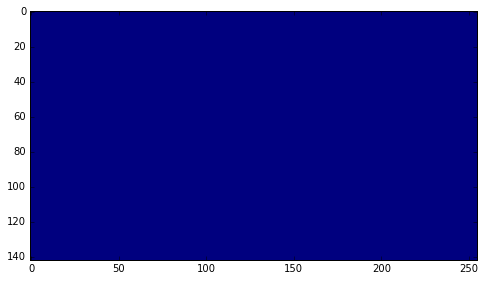

In [22]:
# Testing results ##################################################################################################
print( n_pix_wofs)
plt.imshow( wofs_mask_xy );

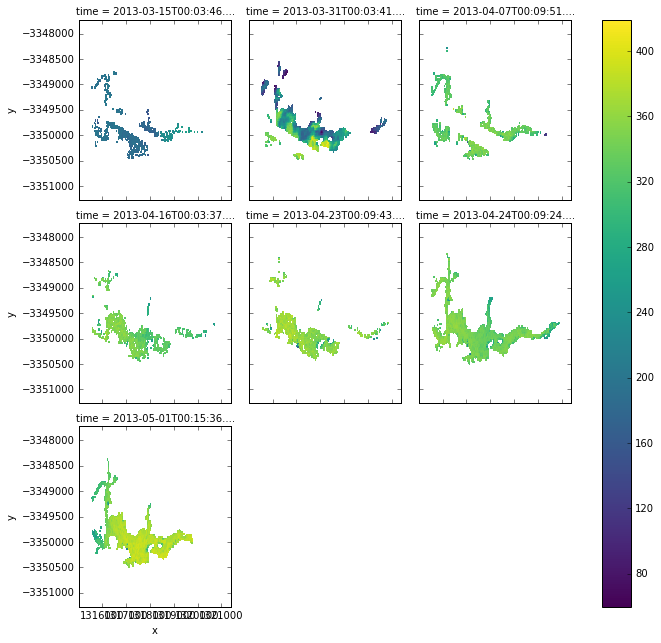

In [23]:
# Testing results ##################################################################################################
if WQ_xarray_TS.shape[0]==1:
    plt.figure()
    WQ_xarray_TS.plot()
else:
    WQ_xarray_TS.plot(col='time', col_wrap=3);

In [24]:
# Testing results ##################################################################################################
sat_flag_list_TS

['LANDSAT_7',
 'LANDSAT_7',
 'LANDSAT_7',
 'LANDSAT_7',
 'LANDSAT_7',
 'LANDSAT_8',
 'LANDSAT_8']

In [25]:
# Testing results ##################################################################################################
low_water_flag_list_TS

['undefined',
 'undefined',
 'true',
 'undefined',
 'true',
 'undefined',
 'undefined']

In [26]:
# Testing results ##################################################################################################
wofs_flag_list_TS

['ephemeral',
 'ephemeral',
 'ephemeral',
 'ephemeral',
 'ephemeral',
 'ephemeral',
 'ephemeral']

### Iteration over polygons: reprojecting to geodetic

In [27]:
# Reproject each time slice to geodetic:
npix_lon = len(lon_vec)
npix_lat = len(lat_vec)
n_dates, npix_y, npix_x = WQ_xarray_TS.shape
WQ_array_TS_geo = np.ones( (n_dates, npix_lat, npix_lon) ) * np.nan

for dd in range(n_dates):
    # WQ gdal dataset:
    gdal_data = gdal.GetDriverByName( 'MEM' ).Create('', npix_x, npix_y, 1, gdal.GDT_Float32)
    gdal_data.SetGeoTransform( sat_geotx )
    gdal_data.SetProjection( sat_proj.ExportToWkt() )
    gdal_data.GetRasterBand(1).WriteArray( WQ_xarray_TS[dd].values, 0, 0)
    
    # reprojected WQ gdal dataset:
    gdal_proj_data = gdal.GetDriverByName( 'MEM' ).Create('', npix_lon, npix_lat, 1, gdal.GDT_Float32)
    gdal_proj_data.SetGeoTransform( (lon_vec[0], pix_size_geo, 0, lat_vec[-1], 0, -pix_size_geo) )
    gdal_proj_data.SetProjection( geo_proj.ExportToWkt() )

    gdal_proj_data.GetRasterBand(1).WriteArray( np.ones((npix_lat,npix_lon))*np.nan, 0, 0)
    tmp = gdal.ReprojectImage( gdal_data, gdal_proj_data,
                               sat_proj.ExportToWkt(), geo_proj.ExportToWkt(),
                               gdal.GRA_NearestNeighbour)
                               # gdal.GRA_Bilinear )   # found to eat away at edges of lake boundaries!...
    WQ_array_TS_geo[dd] = gdal_proj_data.ReadAsArray()

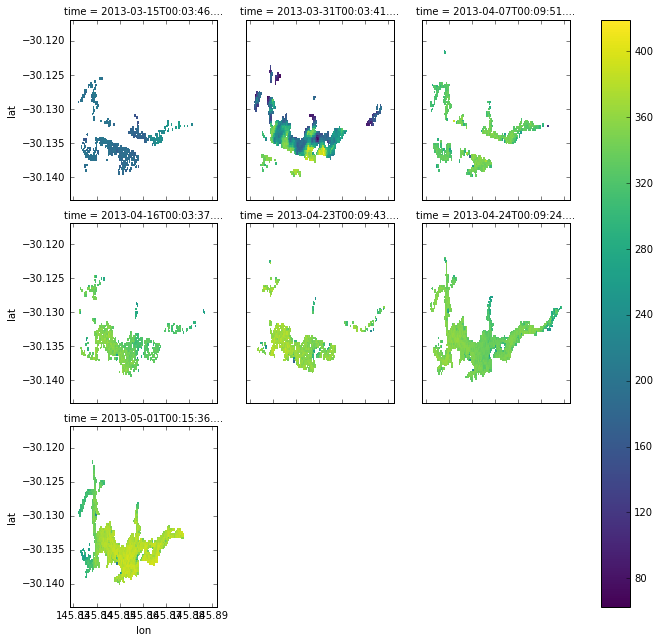

In [28]:
# Testing results ##################################################################################################
WQ_xarray_TS_geo = xr.DataArray( WQ_array_TS_geo, 
                                 coords=[ ('time', WQ_xarray_TS['time'].values), 
                                          ('lat', lat_vec[::-1]), ('lon', lon_vec) ] )
if WQ_xarray_TS_geo.shape[0]==1:
    plt.figure()
    WQ_xarray_TS_geo.plot()
else:
    WQ_xarray_TS_geo.plot(col='time',col_wrap=3);

In [29]:
# Lake stats & Green-Amber-Red flags:
mean_vec = np.nanmean( WQ_array_TS_geo, (1,2) )
med_vec = np.nanmedian( WQ_array_TS_geo, (1,2) )
max_vec = np.nanmax( WQ_array_TS_geo, (1,2) )
min_vec = np.nanmin( WQ_array_TS_geo, (1,2) )

if np.size(alert_thresholds)==1:   # np.nan
    GAR_flag_list = ['undefined' for ii in range(n_dates)]
else:
    amb_idx = np.where( np.nansum( WQ_array_TS_geo>alert_thresholds[0], (1,2) )>0 )[0]
    red_idx = np.where( np.nansum( WQ_array_TS_geo>alert_thresholds[1], (1,2) )>0 )[0]
    GAR_flag_list = ['green' for ii in range(n_dates)]
    for ii in amb_idx: GAR_flag_list[ii] = "amber"
    for ii in red_idx: GAR_flag_list[ii] = "red"

In [30]:
# Testing results ##################################################################################################
GAR_flag_list

['undefined',
 'undefined',
 'undefined',
 'undefined',
 'undefined',
 'undefined',
 'undefined']

### Iteration over polygons: saving to NetCDF

In [31]:
# Extracting dates in datetime format:
dt_dates = np.zeros(n_dates).astype(datetime)
for ii in range(n_dates):
    tmp = str( WQ_xarray_TS['time'].values[ii] )
    dt_dates[ii] = datetime( int(tmp[0:4]), int(tmp[5:7]), int(tmp[8:10]), int(tmp[11:13]), 
                             int(tmp[14:16]), int(tmp[17:19]), int(tmp[20:26]) )

dt_units = netcdf_time_units
dt_calendar = netcdf_time_calendar
dt_dates = date2num(dt_dates, units=dt_units, calendar=dt_calendar )

In [32]:
if append_to_existing_nc:   # append to existing NetCDF file
    
    roi_nc_grp = Dataset(roi_save_name, mode='a')
    n_ex_dates = roi_nc_grp.dimensions['time'].size   # nr of existing dates
    idx = np.arange(n_ex_dates, n_ex_dates+n_dates)
    
    # load and append to variables:
    wq_vals = roi_nc_grp.variables['WQ_data']
    wq_vals[idx,:,:] = WQ_array_TS_geo
    
    times = roi_nc_grp.variables['time']
    times[idx] = dt_dates
    
    mean_vals = roi_nc_grp.variables['WQ_means']
    mean_vals[idx] = mean_vec
    
    med_vals = roi_nc_grp.variables['WQ_medians']
    med_vals[idx] = med_vec
    
    max_vals = roi_nc_grp.variables['WQ_maxvals']
    max_vals[idx] = max_vec
    
    min_vals = roi_nc_grp.variables['WQ_minvals']
    min_vals[idx] = min_vec
    
    sat_vals = roi_nc_grp.variables['satellite_flags']
    sat_vals[idx] = np.array(sat_flag_list_TS)
    
    water_vals = roi_nc_grp.variables['low_water_flags']
    water_vals[idx] = np.array(low_water_flag_list_TS)
    
    wofs_vals = roi_nc_grp.variables['wofs_flags']
    wofs_vals[idx] = np.array(wofs_flag_list_TS)
    
    gar_vals = roi_nc_grp.variables['GAR_flags']
    gar_vals[idx] = np.array(GAR_flag_list)
    
    roi_nc_grp.DateLastUpdated = datetime.now().strftime('%Y/%m/%d %H:%M:%S')
    
    roi_nc_grp.close()
    print( "  WQ and ancillary data appended to file '{}'.".format(roi_save_name) )
    
else:   # create new or replace existing NetCDF file
    
    # backup the existing NetCDF file if desired
    if roi_file_exists & backup_if_replacing_nc:
        # create backup directory:
        bak_dir_path = save_dir_path + 'backup/'
        if not os.path.exists( bak_dir_path ):
            os.makedirs( bak_dir_path )
        if not os.path.exists( bak_dir_path ):
            raise RuntimeError("Could not create directory '{}'.".format(bak_dir_path) )
        print( "  Created backup directory '{}'.".format(bak_dir_path) )
        
        # create backup:
        tmp = bak_dir_path+roi_file_str
        os.rename(roi_save_name, tmp)
        if not os.path.isfile( tmp ):
            raise RuntimeError( "Could not back up NetCDF file '{}'.".format(tmp) )
        print( "  Existing NetCDF file backed up to '{}'.".format(tmp) )
    #---end if
    
    # open NetCDF dataset:
    roi_nc_grp = Dataset(roi_save_name, mode='w')   # overwrites existing file

    # create NetCDF dimensions
    time = roi_nc_grp.createDimension("time", None)   # unlimited dimension
    lat = roi_nc_grp.createDimension("lat", len(lat_vec) )
    lon = roi_nc_grp.createDimension("lon", len(lon_vec) )

    # create NetCDF variables
    times = roi_nc_grp.createVariable("time","f8",("time",))
    lats = roi_nc_grp.createVariable("lat","f8",("lat",))
    lons = roi_nc_grp.createVariable("lon","f8",("lon",))

    wq_vals = roi_nc_grp.createVariable("WQ_data","f8",("time","lat","lon",))
    mean_vals = roi_nc_grp.createVariable("WQ_means","f8",("time",))
    med_vals = roi_nc_grp.createVariable("WQ_medians","f8",("time",))
    max_vals = roi_nc_grp.createVariable("WQ_maxvals","f8",("time",))
    min_vals = roi_nc_grp.createVariable("WQ_minvals","f8",("time",))
    
    sat_vals = roi_nc_grp.createVariable("satellite_flags","S32",("time",))   # Define str length long enough for flags!
    water_vals = roi_nc_grp.createVariable("low_water_flags","S16",("time",))   # Define str length long enough for flags!
    wofs_vals = roi_nc_grp.createVariable("wofs_flags","S64",("time",))   # Define str length long enough for flags!
    gar_vals = roi_nc_grp.createVariable("GAR_flags","S8",("time",))   # Define str length long enough for flags!
    
    # assign values to variables
    times.units = dt_units
    times.calendar = dt_calendar
    times[:] = dt_dates
    lons[:] = lon_vec
    lats[:] = lat_vec[::-1]

    wq_vals[:,:,:] = WQ_array_TS_geo
    mean_vals[:] = mean_vec
    med_vals[:] = med_vec
    max_vals[:] = max_vec
    min_vals[:] = min_vec
    
    sat_vals[:] = np.array(sat_flag_list_TS)
    water_vals[:] = np.array(low_water_flag_list_TS)
    wofs_vals[:] = np.array(wofs_flag_list_TS)
    gar_vals[:] = np.array(GAR_flag_list)
    
    # dataset attributes:
    roi_nc_grp.Name = lakes_name_list[ftr]
    roi_nc_grp.DisplayName = lakes_dispname_list[ftr]
    roi_nc_grp.EPSG = geo_proj.GetAttrValue("AUTHORITY", 1)
    roi_nc_grp.LakeType = "undefined"   # clear/deep vs. turbid/shallow ... should be defined somehow!
    roi_nc_grp.WQtype = WQ_type
    roi_nc_grp.GAR_thresholds = alert_thresholds
    roi_nc_grp.DateCreated = datetime.now().strftime('%Y/%m/%d %H:%M:%S')
    roi_nc_grp.DateLastUpdated = "NA"
    
    roi_nc_grp.close()
    
    if not os.path.isfile( roi_save_name ):
        raise FileNotFoundError("Could not create NetCDF file '{}'.".format(roi_save_name) )
    print( "  WQ and ancillary data saved to file '{}'.".format(roi_save_name) )
#---end if append_to_existing_nc

  WQ and ancillary data saved to file '/g/data/jr4/vis_data_v2.0/EIGHT_MILE.nc'.


total 86M
drwxr-sr-x 3 eal599 jr4 4.0K Aug  3 08:44 .
drwxrws--- 6 root   jr4 4.0K Jul 22 08:36 ..
drwxr-sr-x 2 eal599 jr4 4.0K Aug  3 08:12 backup
-rw-r--r-- 1 eal599 jr4  86M Aug  3 08:44 EIGHT_MILE.nc

 <type 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    Name: EIGHT_MILE
    DisplayName: EIGHT MILE
    EPSG: 4326
    LakeType: undefined
    WQtype: Alg2:TwoBand_TSS_calib
    GAR_thresholds: nan
    DateCreated: 2016/08/03 08:44:50
    DateLastUpdated: NA
    dimensions(sizes): time(7), lat(106), lon(256)
    variables(dimensions): float64 time(time), float64 lat(lat), float64 lon(lon), float64 WQ_data(time,lat,lon), float64 WQ_means(time), float64 WQ_medians(time), float64 WQ_maxvals(time), float64 WQ_minvals(time), <type 'str'> satellite_flags(time), <type 'str'> low_water_flags(time), <type 'str'> wofs_flags(time), <type 'str'> GAR_flags(time)
    groups: 

Global attr. Name = EIGHT_MILE
Global attr. DisplayName = EIGHT MILE
Global attr. EPSG =

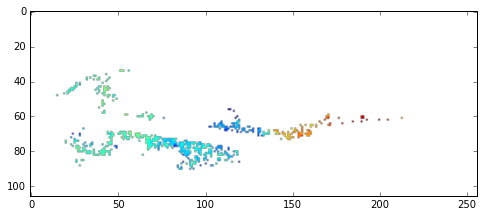

In [33]:
# Testing results ##################################################################################################
!ls -lah /g/data/jr4/vis_data_v2.0/

roi_nc_grp = Dataset(roi_save_name, mode='r')
print( "\n", roi_nc_grp )
for name in roi_nc_grp.ncattrs():
    print( "Global attr.", name, "=", getattr(roi_nc_grp,name) )
print( "\n", roi_nc_grp.variables )
print( "\n", roi_nc_grp.variables['WQ_means'][:] )
print( "\n", roi_nc_grp.variables['WQ_maxvals'][:] )
print( "\n", roi_nc_grp.variables['satellite_flags'][:] )
print( "\n", roi_nc_grp.variables['GAR_flags'][:] )
print( "\n", roi_nc_grp.variables['low_water_flags'][:] )
print( "\n", roi_nc_grp.variables['wofs_flags'][:] )
plt.imshow( roi_nc_grp.variables['WQ_data'][0])
# plt.figure(); plt.imshow( roi_nc_grp.variables['WQ_data'][7])
roi_nc_grp.close()

### Iteration over polygons: CPU usage

In [34]:
area_ha = shape_list[ftr]/10000.0
window_days = (roi_end_date - roi_start_date).days

poly_t1 = timer.time()
delta_t = poly_t1 - poly_t0
print( "  Total time processing polygon (h:m:s):", str(timedelta(seconds=delta_t)) )

print( "    Processing time (sec.) per ha per day (time window:",window_days,"days):", delta_t/area_ha/window_days )
print( "    Processing time (sec.) per ha per time slice (all",n_dates_orig,"available):", delta_t/area_ha/n_dates_orig )
print( "    Processing time (sec.) per ha per time slice (final series:",n_dates,"dates):", delta_t/area_ha/n_dates )

  Total time processing polygon (h:m:s): 0:02:18.520862
    Processing time (sec.) per ha per day (time window: 62 days): 0.00677153946312
    Processing time (sec.) per ha per time slice (all 27 available): 0.0155494609894
    Processing time (sec.) per ha per time slice (final series: 7 dates): 0.0599764923877
